# 결정 트리 (Decision Tree) - 분류

- 스무고개처럼 질문/결정을 통해 데이터를 분류하는 모델
    - 데이터 스케일링 영향이 적음
    - 선형 구조가 아닌 복잡한 구조의 데이터에 적합
    - 과대적합 되기 쉬움 -> 가지치기 등을 통해 과대적합 방지

**하이퍼 파라미터**

<table>
  <thead>
    <tr>
      <th>파라미터 명</th>
      <th>설명</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><code>max_depth</code></td>
      <td>
        트리의 최대 깊이를 규정 (디폴트: None) <br>
        None으로 설정하면 완벽하게 클래스 결정 값이 될 때까지 깊이를 계속 키우며 분할하거나 노드가 가지는 데이터 개수가 <code>min_samples_split</code>보다 작아질 때까지 계속 깊이를 증가시킴 <br>
        깊이가 길어지면 <code>min_samples_split</code> 설정대로 최대 분할하여 과적합할 수 있으므로 적절한 값으로 제어 필요
      </td>
    </tr>
    <tr>
      <td><code>max_features</code></td>
      <td>
        최적의 분할을 위해 고려할 최대의 피처 개수 (디폴트: None / 데이터셋의 모든 피처를 사용해 분할 수행)
        <ul>
          <li><code>int</code> 형으로 지정하면 대상 피처의 개수, <code>float</code> 형으로 지정하면 전체 피처 중 대상 피처의 퍼센트</li>
          <li><code>'sqrt'</code>는 전체 피처 중 sqrt(전체 피처 개수) 즉, 전체 피처 개수의 제곱근만큼 선택</li>
          <li><code>'auto'</code>로 지정하면 sqrt와 동일</li>
          <li><code>'log'</code>는 전체 피처 중 log2(전체 피처 개수) 선택</li>
          <li><code>'None'</code>은 전체 피처 선택</li>
        </ul>
      </td>
    </tr>
    <tr>
      <td><code>min_samples_split</code></td>
      <td>
        노드 분할을 위한 최소 samples (디폴트 : <code>min_samples_split=2</code> == 부모노드의 sample수가 2 이상인 경우 분할, 자식노드의 sample수가 2이하일 수 있음) <br>
        작게 설정할 수록 과적합 가능성 증가
      </td>
    </tr>
    <tr>
      <td><code>min_samples_leaf</code></td>
      <td>
        분할 이후 만족시켜야 할 sample 최소 개수 (<code>min_samples_leaf=2</code>일 때, 분할 이후 자식노드의 sample수가 2개 이상이 된다면 부모노드를 분할) <br>
        작게 설정할수록 과적합 가능성 증가
      </td>
    </tr>
    <tr>
      <td><code>max_leaf_nodes</code></td>
      <td>분할 이후 leaf_node 최대개수</td>
    </tr>
    <tr>
      <td><code>criterion</code></td>
      <td>
        분할을 위해 사용할 성능 평가 지표 설정 <br>
        <code>gini</code> 또는 <code>entropy</code> 값을 사용할 수 있으며, <code>gini</code>는 지니 계수를, <code>entropy</code>는 정보 이득을 기반으로 분할 기준을 결정
      </td>
    </tr>
    <tr>
      <td><code>min_weight_fraction_leaf</code></td>
      <td>
        리프 노드가 전체 가중치에서 차지해야 하는 최소 비율 (디폴트: 0) <br>
        특정 클래스의 데이터가 지나치게 적은 경우 과적합을 방지하기 위해 사용
      </td>
    </tr>
  </tbody>
</table>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

##### graphviz 설치
- 그래프 시각화를 위한 오픈소스 소프트웨어 도구
1. os에 설치
2. python wrapper package 설치
3. plot_tree 사용

In [2]:
# !pip install graphviz # import 할 필요없이 내부적으로 사용이 가능함

---

### WINE 이진 분류
- 와인 품질 데이터셋을 가공한 레드/화이트 와인 이진분류 데이터셋
    - 0: 레드 와인
    - 1: 화이트 화인

In [3]:
# 데이터 로드
wine_df = pd.read_csv('./data/wine_simple.csv')
wine_df

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0
...,...,...,...,...
6492,11.2,1.6,3.27,1.0
6493,9.6,8.0,3.15,1.0
6494,9.4,1.2,2.99,1.0
6495,12.8,1.1,3.34,1.0


In [4]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


In [5]:
wine_df.describe()

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [30]:
# 데이터 분리 및 스케일링
# target data: class

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. 데이터 분리
X = wine_df.drop('class', axis=1)
y = wine_df['class']
print(y.value_counts()) # 1: white, 0: red wine -> num(white)>num(red)

# 2. train - test 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# 3. 학습 - 테스트 데이터 정규화
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train) # 학습 데이터는 fit&transform
# X_test = scaler.transform(X_test) # 테스트 데이터는 transform만

class
1.0    4898
0.0    1599
Name: count, dtype: int64


((4872, 3), (1625, 3), (4872,), (1625,))

In [31]:
# 4. 모델 학습 및 평가
from sklearn.tree import DecisionTreeClassifier # 결정트리분류 모델 추가

# dt_clf = DecisionTreeClassifier(random_state=0)
dt_clf = DecisionTreeClassifier(random_state=0, max_depth=3) # 0.8499589490968801, 0.8363076923076923 -> max_depth를 설정하기 전에는 과적합이었지만 max_depth를 설정한 후로는 과적합이 해결된 것을 확인할 수 있음 -> pre prunning(사전 가지치기)

dt_clf.fit(X_train, y_train)
dt_clf.score(X_train, y_train), dt_clf.score(X_test, y_test) # 0.9973316912972086, 0.8467692307692307 -> 거의 100임 -> 과적합 상태라는 것을 추측할 수 있음

(0.8433908045977011, 0.8584615384615385)

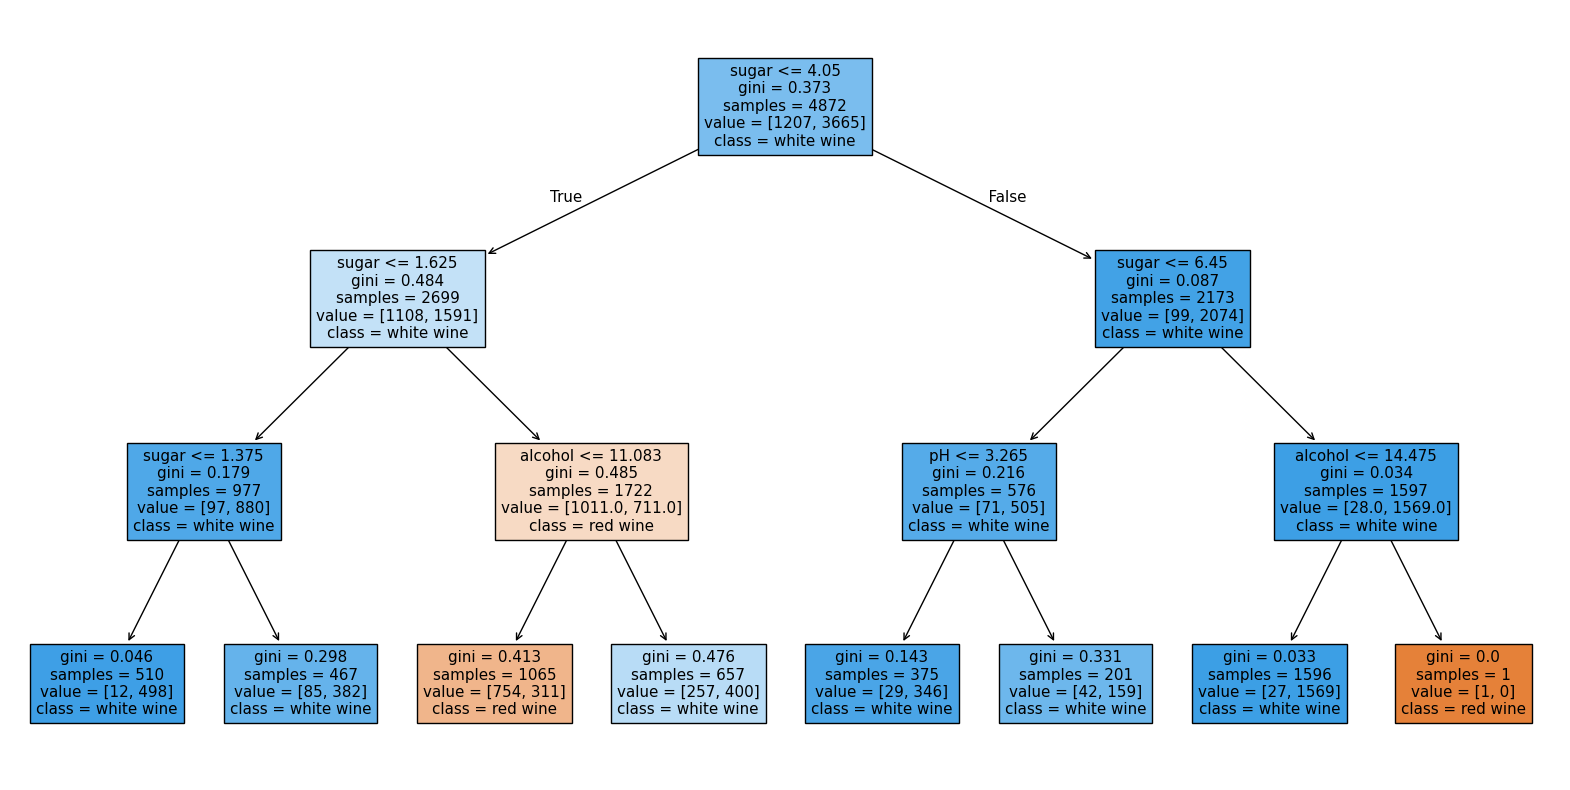

'\nsugar <= -0.284         # decision tree classifier가 정한 분할 기준 (자식 노드에서 지니계수가 최대로 낮아질 수 있는 분할 기준)\ngini = 0.373            # 지니계수 = 1 - (음성클래스 비율^2 + 양성 클래스 비율^2) # 지니계수: 최적의 분할을 찾을 때 불순도가 낮은 분할을 선택하기 위해 사용함 즉, 여러가지 분할을 시도한 후 각 분할에서 가장 낮은 지니계수를 계산함\nsamples = 4872          # 현재 노드의 전체 샘플 수\nvalue = [1207,3665]     # 클래스별 샘플 개수 [0번 클래스 개수, 1번 클래스 개수]\nclass = white wine      # 현재 노드의 클래스\n'

In [32]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
# plot_tree(dt_clf) # pltot_tree에 결정트리분류 모델 자체를 넣음
plot_tree(
    dt_clf, # 대상이 되는 모델
    filled=True, # 색 채우기 옵션 (특정 클래스의 비율을 표현)
    feature_names=X.columns, # 특성을 이름으로 쓸 수 있게 하는 옵션
    class_names=['red wine','white wine'], # red:0, white:1이라 그 순서로 클래스 이름을 설정
    # max_depth=3 # post prunning(사후 가지치기)
)
plt.savefig('wine_simple.png') # 이미지 저장
plt.show()

'''
sugar <= -0.284         # decision tree classifier가 정한 분할 기준 (자식 노드에서 지니계수가 최대로 낮아질 수 있는 분할 기준)
gini = 0.373            # 지니계수 = 1 - (음성클래스 비율^2 + 양성 클래스 비율^2) # 지니계수: 최적의 분할을 찾을 때 불순도가 낮은 분할을 선택하기 위해 사용함 즉, 여러가지 분할을 시도한 후 각 분할에서 가장 낮은 지니계수를 계산함
samples = 4872          # 현재 노드의 전체 샘플 수
value = [1207,3665]     # 클래스별 샘플 개수 [0번 클래스 개수, 1번 클래스 개수]
class = white wine      # 현재 노드의 클래스
'''

In [17]:
# 지니 불순도 직접 계산
# 지니계수 = 1 - (음성클래스 비율^2 + 양성 클래스 비율^2)
1 - ((1207/4872)**2 + (3665/4872)**2)

0.37273200500969317

In [ ]:
# 특성 중요도
# [alcohol, sugar, pH]
# - 지니불순도 감소에 기여한 만큼 중요도가 높아짐
print(dt_clf.feature_importances_) # 모델이 판단한 특성의 중요도 [0.11483515, 0.87892904, 0.00623581] 

[0.11483515 0.87892904 0.00623581]


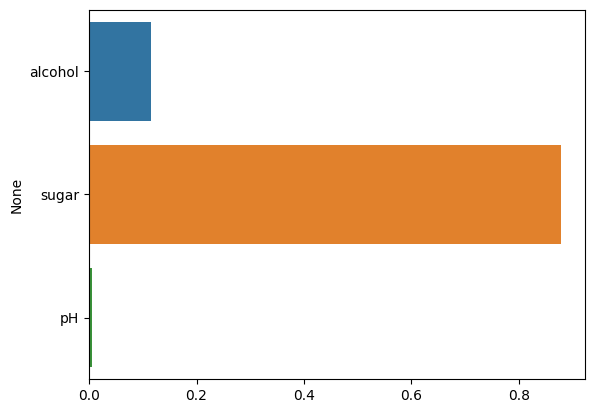

In [ ]:
# 특성 중요도 시각화
sns.barplot(x=dt_clf.feature_importances_, y=X.columns, hue=X.columns) # hue로 색을 다르게 지정
plt.show()

##### iris 다중분류

In [83]:
# 데이터 로드
from sklearn.datasets import load_iris

iris_data = load_iris() # .data: X 데이터, .target: y 데이터
iris_data.target_names


array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [62]:
from sklearn.model_selection import train_test_split

# 1. 데이터 분리
X = iris_data.data
y = iris_data.target

# 2. 학습 - 테스트 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# 3. 정규화 생략

In [ ]:
# 4. 모델 학습 및 평가
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=0) # max_depth

dt_clf.fit(X_train, y_train)
dt_clf.score(X_train, y_train), dt_clf.score(X_test, y_test) # 기본적으로 회귀모델은 score에서 r2 스코어를 반환

(1.0, 0.9736842105263158)

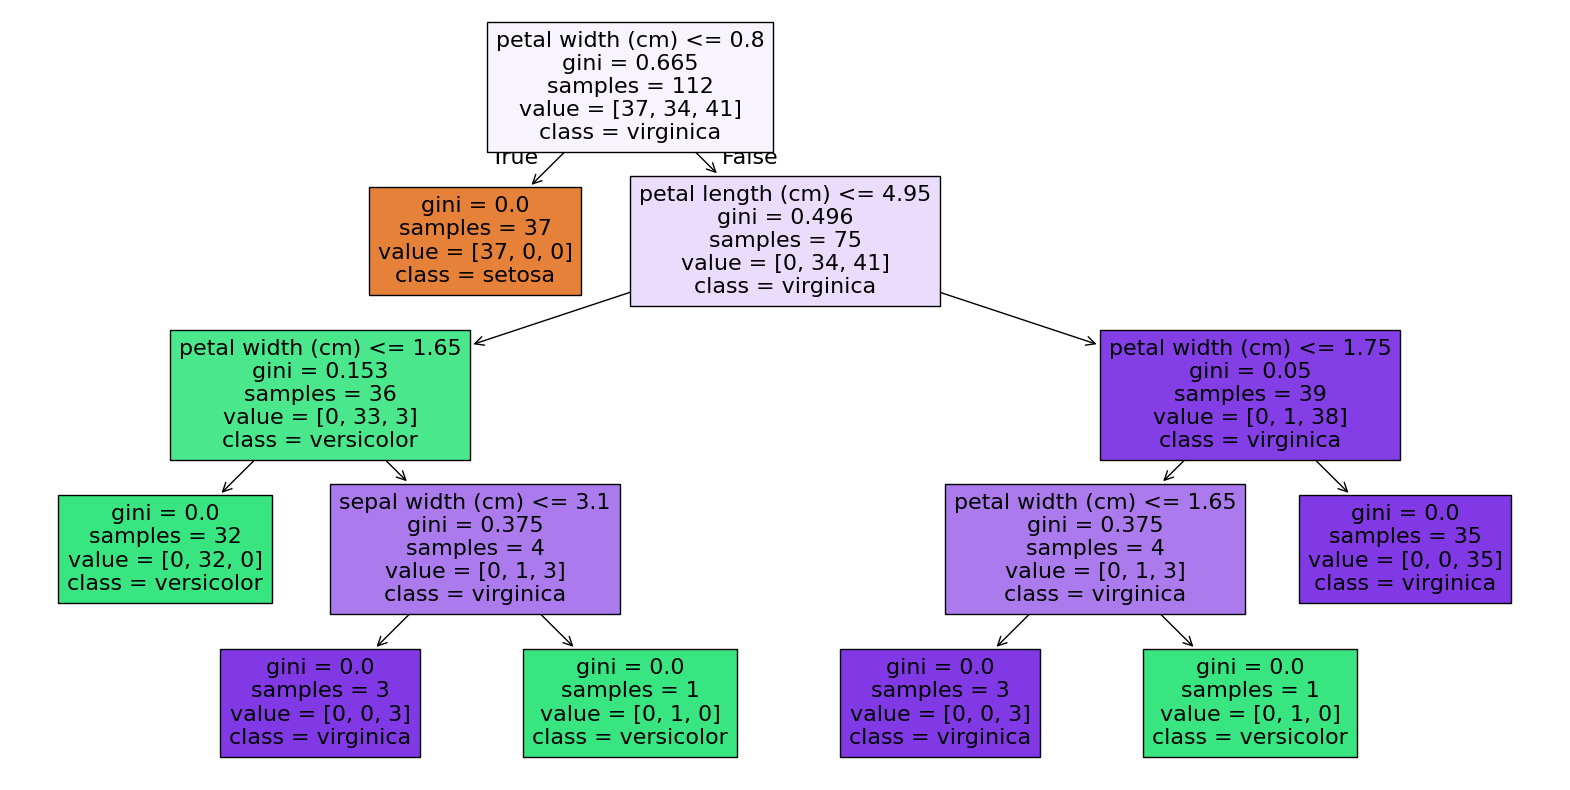

In [72]:
# 트리 모델 시각화

from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(
    dt_clf,
    filled=True,
    feature_names=iris_data.feature_names,
    class_names=iris_data.target_names
)
plt.show()

In [113]:
dt_clf.feature_importances_

array([0.        , 0.02014872, 0.39927524, 0.58057605])

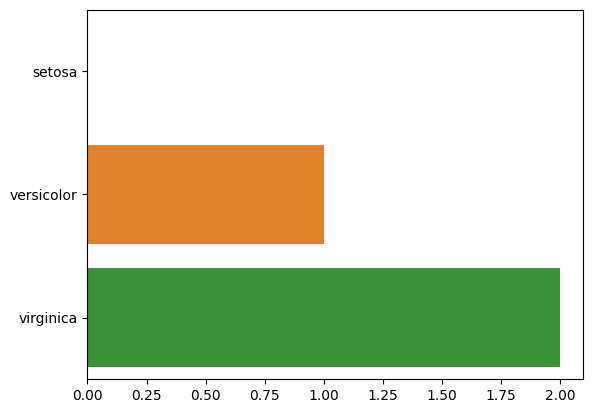

In [ ]:
# ❓이게 맞나요
sns.barplot(x=dt_clf.classes_, y=iris_data.target_names, hue=iris_data.target_names)
plt.show()

# DecisionTreeRegressor - 회귀
- 각 노드에서 MSE를 최소화하는 방향으로 노드 분할
- 최종 노드(리프 노드)에서는 각 샘플들의 평균값을 계산해 예측값으로 사용

In [ ]:
# 데이터 로드
from sklearn.datasets import fetch_california_housing

housing_data = fetch_california_housing()

housing_df = pd.DataFrame(housing_data.data, columns=housing_data.feature_names)
# print(housing_data.target)
housing_df[housing_data.target_names[0]]=housing_data.target # housing 데이터에 컬럼을 추가
housing_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [99]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [116]:
# 데이터 준비 (분리)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(housing_data.data, housing_data.target, random_state=0)

In [120]:
# 모델 훈련 및 평가
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=6) # max_depth는 규제 파라미터로 이걸 이용하면 과적합을 해결할 수 있음

# 학습
dt_reg.fit(X_train, y_train)

# 예측
pred_train = dt_reg.predict(X_train)
pred_test = dt_reg.predict(X_test)

# 평가
mse_train = mean_squared_error(y_train, pred_train) # 실제값과 예측값
r2_train = r2_score(y_train, pred_train) # 실제값과 예측값

mse_test = mean_squared_error(y_test, pred_test) # 실제값과 예측값
r2_test = r2_score(y_test, pred_test) # 실제값과 예측값

print('train 데이터 평가: ', mse_train, '|', r2_train)
print('test 데이터 평가: ', mse_test, '|', r2_test)

train 데이터 평가:  0.4318889116951823 | 0.6764024522568706
test 데이터 평가:  0.5019919894761429 | 0.6202354722120249


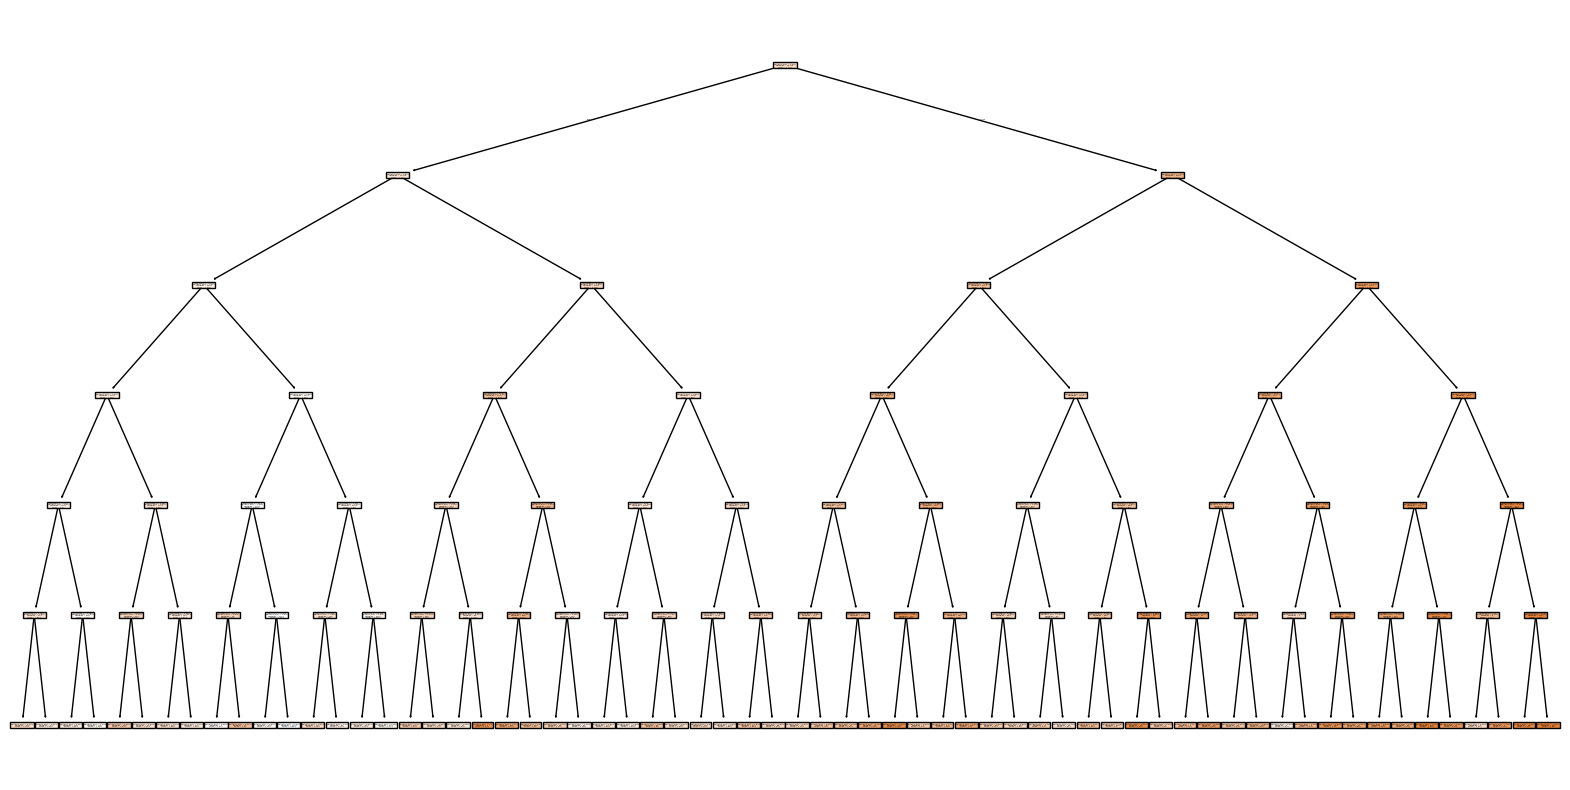

In [121]:
# 시각화
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(
    dt_reg,
    filled=True,
    feature_names=housing_data.feature_names
)
plt.show()

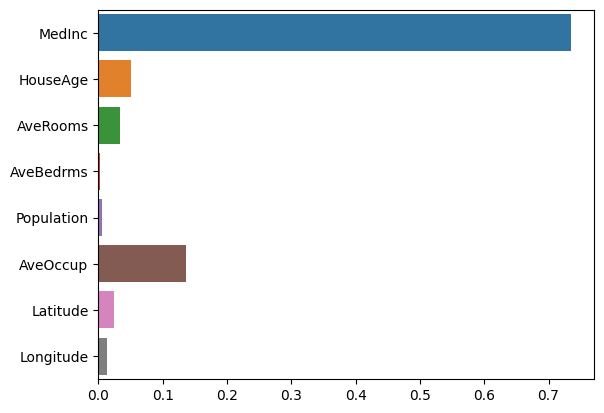

In [ ]:
# 특성 중요도
dt_reg.feature_importances_
sns.barplot(x=dt_reg.feature_importances_, y=housing_data.feature_names, hue=housing_data.feature_names)
plt.show()